# **Import and Install**

In [2]:
import re
import math
import emoji
import string
import pickle
import collections
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import AutoTokenizer, TrainingArguments, AutoModelForSequenceClassification, AutoModelForTokenClassification, Trainer
from sklearn.model_selection import train_test_split
from sklearn import pipeline
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
from wordcloud import WordCloud

# **Dataset Preprocessing**

In [3]:
df = pd.read_csv('../datasets/apple_iphone_11_reviews.csv')

In [4]:
print(f'Before:\n{df.isnull().sum()}')
df.dropna(subset=['review_text'], inplace=True)
df.dropna(subset=['review_title'], inplace=True)
print()
print(f'After:\n{df.isnull().sum()}')

Before:
index              0
product            0
helpful_count      0
total_comments     0
url                0
review_country     0
reviewed_at        0
review_text        3
review_rating      0
product_company    0
profile_name       0
review_title       2
dtype: int64

After:
index              0
product            0
helpful_count      0
total_comments     0
url                0
review_country     0
reviewed_at        0
review_text        0
review_rating      0
product_company    0
profile_name       0
review_title       0
dtype: int64


# **EDA**

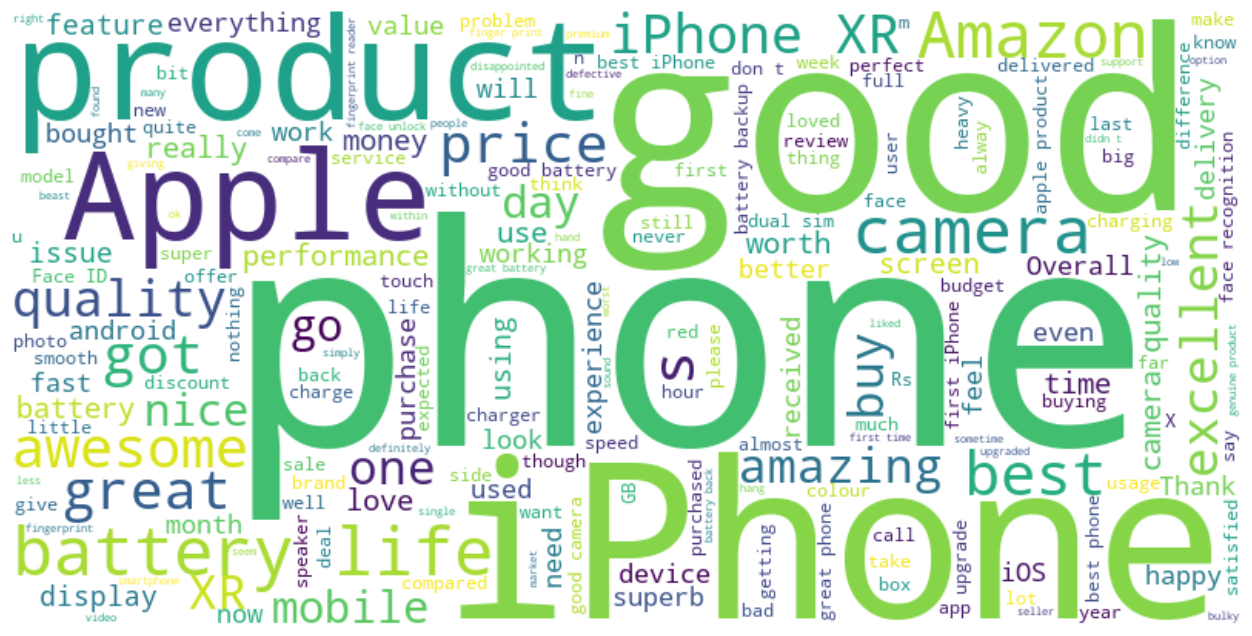

In [5]:
text = ''.join(df['review_text'].astype(str))
wordcloud = WordCloud(width=800, height=400, max_font_size=200, background_color="white").generate_from_text(text)

plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

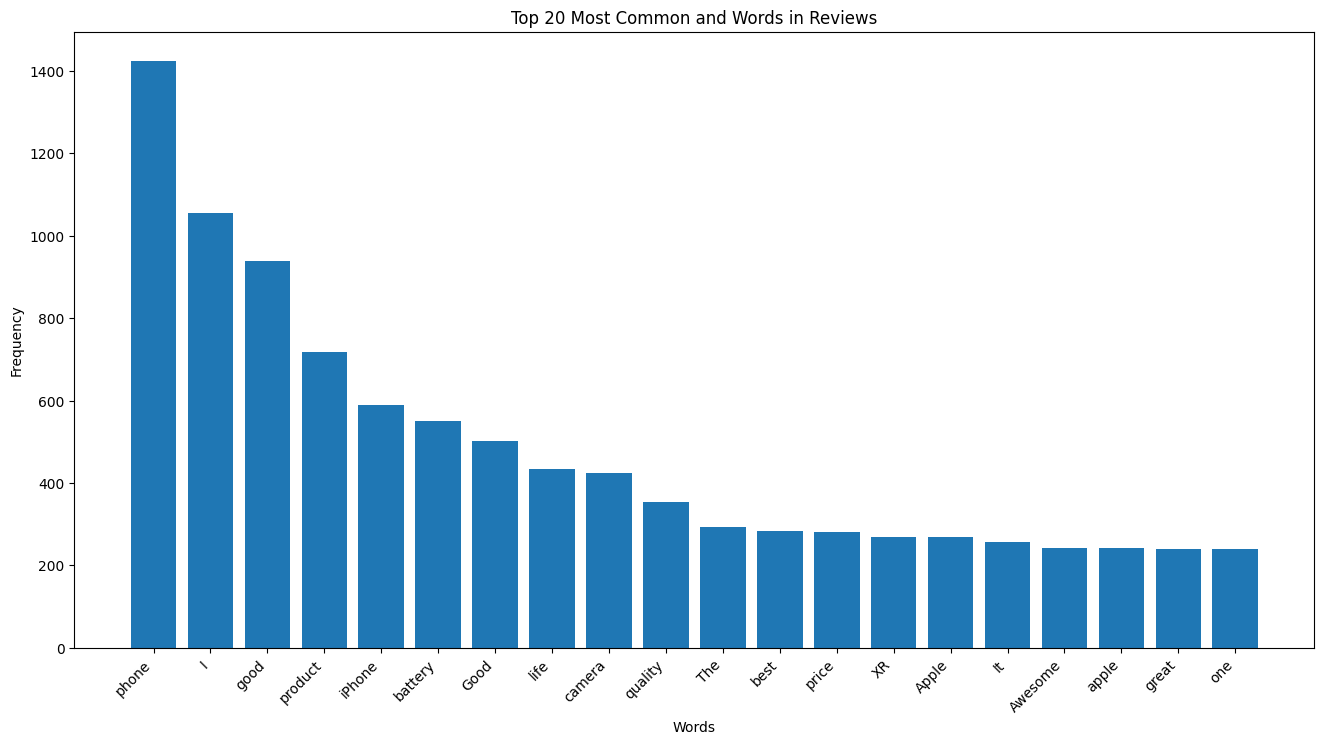

In [6]:
plt.figure(figsize=(16, 8))
reviews = df['review_text']
all_words = []
for text in reviews:
  sentences = word_tokenize(str(text))
  words = [word for word in sentences if word not in string.punctuation]
  words = [word for word in words if word not in stopwords.words('english')]
  words = [word for word in words if word.isalpha()]
  all_words.extend(words)

word_freq = collections.Counter(all_words)
common_words = word_freq.most_common(20)
words, frequencies = zip(*common_words)

plt.bar(words, frequencies)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Common and Words in Reviews')
plt.show()

# **Sentiment Analysis**

## **Copy dataframe for Sentiment Analysis purpose**

In [22]:
sentiment_df = df

## **Data Labeling**

In [23]:
def label_rating(review_rating):
  match = re.search(r'(\d+(\.\d+))\s*out of 5 stars', review_rating)
  if match:
    return float(match.group(1))
  else:
    return None

sentiment_df['numeric_rating'] = sentiment_df['review_rating'].apply(label_rating)
print(sentiment_df['numeric_rating'])


none_values = sentiment_df['numeric_rating'].isna()
none_count = none_values.sum()
print("None values: ", none_count)

0       3.0
1       1.0
2       5.0
3       1.0
4       5.0
       ... 
5005    4.0
5006    4.0
5007    5.0
5008    5.0
5009    5.0
Name: numeric_rating, Length: 5007, dtype: float64
None values:  0


In [24]:
def apply_labels(numeric_rating):
  if numeric_rating < 3:
    label = 'bad'
  elif numeric_rating == 3:
    label = 'neutral'
  else:
    label = 'good'
  return label

sentiment_df['label'] = sentiment_df['numeric_rating'].apply(apply_labels)
print(sentiment_df['label'])

0       neutral
1           bad
2          good
3           bad
4          good
         ...   
5005       good
5006       good
5007       good
5008       good
5009       good
Name: label, Length: 5007, dtype: object


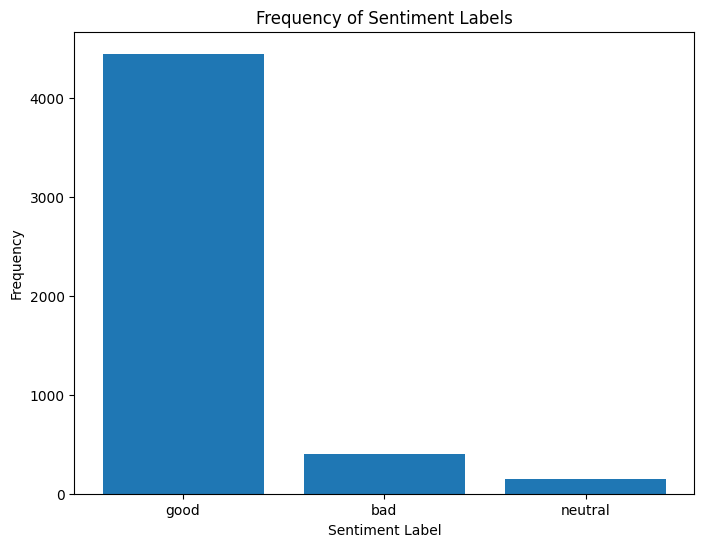

In [25]:
label_counts = sentiment_df['label'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Sentiment Label')
plt.ylabel('Frequency')
plt.title('Frequency of Sentiment Labels')
plt.show()

## **Data Resampling**

In [26]:
neutral = sentiment_df[sentiment_df['label'] == 'neutral']
bad = sentiment_df[sentiment_df['label'] == 'bad']
good = sentiment_df[sentiment_df['label'] == 'good']

neutral_upsampled = neutral.sample(n=len(good), replace=True, random_state = 20)
bad_upsampled = bad.sample(n=len(good), replace=True, random_state = 20)

up_data = pd.concat([neutral_upsampled, bad_upsampled, good])

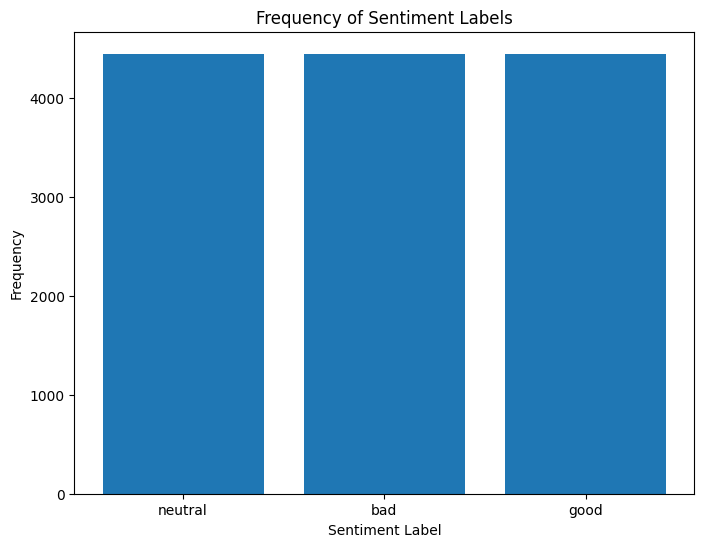

In [27]:
label_counts = up_data['label'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Sentiment Label')
plt.ylabel('Frequency')
plt.title('Frequency of Sentiment Labels')
plt.show()

## **Train test split**

In [28]:
train, eval = train_test_split(up_data,train_size=0.8,stratify=up_data['label'])

print(train)
print(eval)

      index                         product                  helpful_count  \
2473   2473  Apple iPhone XR (64GB) - Black                              0   
3064   3064  Apple iPhone XR (64GB) - Black                              0   
558     558  Apple iPhone XR (64GB) - Black    2 people found this helpful   
1934   1934  Apple iPhone XR (64GB) - Black                              0   
861     861  Apple iPhone XR (64GB) - Black  One person found this helpful   
...     ...                             ...                            ...   
2222   2222  Apple iPhone XR (64GB) - Black                              0   
712     712  Apple iPhone XR (64GB) - Black                              0   
802     802  Apple iPhone XR (64GB) - Black                              0   
3473   3473  Apple iPhone XR (64GB) - Black                              0   
4027   4027  Apple iPhone XR (64GB) - Black                              0   

      total_comments                                           

## **Training Model**

### **Tokenizing**

In [ ]:
tokenizer=AutoTokenizer.from_pretrained('distilbert-base-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
train['review_text'] = train['review_text'].astype(str)
eval['review_text'] = eval['review_text'].astype(str)

label_mapping = {'bad': 0, 'neutral': 1, 'good': 2}

train['label'] = train['label'].map(label_mapping)
eval['label'] = eval['label'].map(label_mapping)

train_dataset = Dataset.from_pandas(train[['review_text', 'label']])
eval_dataset = Dataset.from_pandas(eval[['review_text', 'label']])

def tokenize_data(batch):
  tokenized_batch = tokenizer(batch['review_text'], padding='max_length', truncation=True, max_length=512)
  tokenized_batch['labels'] = batch['label']
  return tokenized_batch

train_dataset = train_dataset.map(tokenize_data, batched=True)
eval_dataset = eval_dataset.map(tokenize_data, batched=True)

print(train['label'].head())
print(eval['label'].head())
print(train_dataset[0])


Map:   0%|          | 0/10675 [00:00<?, ? examples/s]

Map:   0%|          | 0/2669 [00:00<?, ? examples/s]

2033    0
4199    1
920     2
2587    2
504     0
Name: label, dtype: int64
1845    0
3282    0
555     0
134     2
119     0
Name: label, dtype: int64
{'review_text': 'My phone is not working properly & I m not satisfy, its cheating done by seller & Amazon is not supporting', 'label': 0, '__index_level_0__': 2033, 'input_ids': [101, 1422, 2179, 1110, 1136, 1684, 7513, 111, 146, 182, 1136, 13692, 117, 1157, 18661, 1694, 1118, 18275, 111, 9786, 1110, 1136, 4374, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    f1 = f1_score(labels, predictions, average='weighted')
    return {"f1-score": f1}

In [ ]:
trainargs=TrainingArguments('tweet_sentiments_analysis_distilbert',
  num_train_epochs=5,
  evaluation_strategy="epoch",
  save_strategy='epoch',
  load_best_model_at_end=True,
  push_to_hub=False
)

### **Training**

In [ ]:
model_name = 'distilbert-base-cased'
num_labels = 3
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

trainer = Trainer(
  model=model,
  args=trainargs,
  train_dataset=train_dataset,
  eval_dataset=eval_dataset,
  tokenizer=tokenizer,
  compute_metrics=compute_metrics,
)

trainer.train()

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1-score
1,0.249200,0.122665,0.966614
2,0.091200,0.109506,0.973028
3,0.059100,0.115392,0.973364
4,0.038100,0.093448,0.975194
5,0.040800,0.091827,0.975189


TrainOutput(global_step=6675, training_loss=0.12260814502444607, metrics={'train_runtime': 2688.8565, 'train_samples_per_second': 19.85, 'train_steps_per_second': 2.482, 'total_flos': 7070573494656000.0, 'train_loss': 0.12260814502444607, 'epoch': 5.0})

## **Evaluation**

In [ ]:
results = trainer.evaluate()
print("DistilBERT model:")
print("Evaluation results:", results)

DistilBERT model:
Evaluation results: {'eval_loss': 0.09182687848806381, 'eval_f1-score': 0.9751889560307472, 'eval_runtime': 42.362, 'eval_samples_per_second': 63.005, 'eval_steps_per_second': 7.884, 'epoch': 5.0}


In [ ]:
#masukin Save model
model.save_pretrained('../model/Sentiment_analysis_model')
tokenizer.save_pretrained('../model/tokenizer_sentiment')

In [ ]:
def tokenize_data_text(input_text):
  tokenized_text = tokenizer(input_text, padding='max_length', truncation=True, max_length=512)
  return tokenized_text

text = 'The Sky is Blue'

tokenize_data_text(text)

clf = pipeline("text-classification", model=model_sentiment, tokenizer=tokenizer_sentiment)

predictions = clf(text)
label_mapping = {'LABEL_0': 'Negative', 'LABEL_1': 'Neutral', 'LABEL_2': 'Possitive'}
predicted_label = label_mapping[predictions[0]['label']]
print('Predicted Label:',predicted_label)
print('Confindence Proabibliy:', predictions[0]['score'])

# **NER**

## **Copy dataframe for NER purpose**

In [8]:
NER_df = pd.DataFrame({'review': df['review_text']})
NER_df.head()

,review
0,NOTE:
1,Very bad experience with this iPhone xr phone....
2,Amazing phone with amazing camera coming from ...
3,So I got the iPhone XR just today. The product...
4,I've been an android user all my life until I ...


## **Data Preprocessing for NER**

In [9]:
camera = ['image', 'picture', 'camera', 'video', 'photography', 'ois', 'eis', 'stabilization']
performance = ['faster', 'cpu', 'performance', 'lag', 'processor', 'power', 'smooth', 'os', 'specification', 'android', 'ios']
screen = ['screen', 'display', 'nits', 'brightness', 'ips', 'hz', 'hertz', 'lcd']
charging = ['charging', 'charge', 'watt', 'port', 'usb']
audio = ['mic', 'microphone', 'audio', 'speaker', 'volume', 'loudspeaker', 'headphone']
connection = ['connection', 'wifi', 'bluetooth']
storage = ['ram', 'rom', 'storage', 'emmc', 'ufs', 'mbps', 'gbps', 'microsd']
feature = ['feature', 'sensor', 'sensors', 'hdr']

In [10]:
def to_iob_tag(data_1, data_2):
	arr = []
	for i, (cleaned_review, tag) in enumerate(zip(data_1, data_2)):
		review_tokenize = word_tokenize(cleaned_review)
		tag_tokenize = word_tokenize(tag)

		for (review_edit, tag_edit) in zip(review_tokenize, tag_tokenize):
			flag = f'Sentence {i + 1}'
			arr.append((flag, review_edit, tag_edit))

	tokenize_df = pd.DataFrame(arr)
	tokenize_df.rename(columns={0: 'Sentence #', 1: 'Word', 2: 'Tag'}, inplace=True)
	tokenize_df["Sentence #"] = LabelEncoder().fit_transform(tokenize_df["Sentence #"])
	tokenize_df.rename(columns={"Sentence #": "sentence_id", "Word": "words", "Tag": "labels"}, inplace =True)
	tokenize_df["labels"] = tokenize_df["labels"].str.upper()
	tokenize_df.dropna(inplace=True)

	return tokenize_df

In [11]:
def tagging_data(text):
  word_token = word_tokenize(text)
  text_dict = ['O'] * len(word_token)

  for i, word in enumerate(word_token):
    word = word.lower()
    if text_dict[i] != 'O':
      continue
    if word in camera:
      text_dict[i] = 'B-camera'
    elif word in performance:
      text_dict[i] = 'B-performance'
    elif word in screen:
      text_dict[i] = 'B-screen'
    elif word in charging:
      text_dict[i] = 'B-charging'
    elif word in audio:
      if re.match(r'\b(audio|headphone)\b', word) and i < len(word_token) - 1 and word_token[i + 1] == 'jack':
        text_dict[i] = 'B-audio'
        text_dict[i + 1] = 'I-audio'
      else:
        text_dict[i] = 'B-audio'
    elif word in connection:
      text_dict[i] = 'B-connection'
    elif word in storage:
      text_dict[i] = 'B-storage'
    elif word in feature:
      text_dict[i] = 'B-feature'
    else:
      if re.match(r'\b\d+(?:gb|mb|kb)\b', word):
        text_dict[i] = 'B-storage'
        if i < len(word_token) - 1 and re.match(r'\b(ram|rom)\b', word_token[i + 1]):
          text_dict[i + 1] = 'I-storage'
      elif re.match(r'\b(amoled|oled)\b', word):
        text_dict[i] = 'B-screen'
        if i < len(word_token) - 1 and re.match(r'\b(display|screen)\b', word_token[i + 1]):
          text_dict[i + 1] = 'I-screen'
      elif re.match(r'\b\d+\-*(?:mp|megapixel)\b', word):
        text_dict[i] = 'B-camera'
      elif re.match(r'\b\d+(?:hz|hertz|p)\b', word):
        text_dict[i] = 'B-screen'
        if i < len(word_token) - 1 and re.match(r'\b(resolution|refresh)\b', word_token[i + 1]):
          text_dict[i + 1] = 'I-screen'
          if i + 2 < len(word_token) - 1 and re.match(r'\brate\b', word_token[i + 2]):
            text_dict[i + 2] = 'I-screen'
      elif word.isnumeric() and i < len(word_token) - 1 and re.match(r'\b(gb|mb|kb)\b', word_token[i + 1]):
        text_dict[i] = 'B-storage'
        text_dict[i + 1] = 'I-storage'
        if i + 2 < len(word_token) - 1 and re.match(r'\b(ram|rom)\b', word_token[i + 2]):
          text_dict[i + 2] = 'I-storage'
      elif word.isnumeric() and i < len(word_token) - 1 and re.match(r'\b(mp|megapixels?)\b', word_token[i + 1]):
        text_dict[i] = 'B-camera'
        text_dict[i + 1] = 'I-camera'
        if i + 2 < len(word_token) - 1 and re.match(r'\b(systems?|sensors?)\b', word_token[i + 2]):
          text_dict[i + 2] = 'I-camera'
      elif word == 'fingerprint' and i < len(word_token) - 1 and re.match(r'\b(scanner|reader)\b', word_token[i + 1]):
        text_dict[i] = 'B-feature'
        text_dict[i + 1] = 'I-feature'
      elif word == 'face' and i < len(word_token) - 1 and re.match(r'\b(unlock|id)\b', word_token[i + 1]):
        text_dict[i] = 'B-feature'
        text_dict[i + 1] = 'I-feature'
      elif word == 'sd' and i < len(word_token) - 1 and word_token[i + 1] == 'card':
        text_dict[i] = 'B-storage'
        text_dict[i + 1] = 'I-storage'
      elif word == 'micro' and i < len(word_token) - 1 and word_token[i + 1] == 'sd':
        text_dict[i] = 'B-storage'
        text_dict[i + 1] = 'I-storage'
      elif re.match(r'\b(macro|main|front|ultrawide|wide|zoom|rear|selfie|depth|telephoto)\b', word) and i < len(word_token) - 1 and re.match(r'\bcameras?\b', word_token[i + 1]):
        text_dict[i] = 'B-camera'
        text_dict[i + 1] = 'I-camera'
        if i + 2 < len(word_token) - 1 and re.match(r'\b(systems?|sensors?)\b', word_token[i + 2]):
          text_dict[i + 2] = 'I-camera'
      elif i < len(word_token) - 1 and re.match(r'\b(cameras?)\b', word) and re.match(r'\bsensors?\b', word_token[i + 1]):
        text_dict[i] = 'B-camera'
        text_dict[i + 1] = 'I-camera'
      elif word == 'operating' and i < len(word_token) - 1 and word_token[i + 1] == 'system':
        text_dict[i] = 'B-performance'
        text_dict[i + 1] = 'I-performance'
      elif re.match(r'\b(proximity|accelerometer|gyroscope|barometer|biometrics)\b', word):
        text_dict[i] = 'B-feature'
        if i < len(word_token) - 1 and re.match(r'\bsensors?\b', word_token[i + 1]):
          text_dict[i + 1] = 'I-feature'
      elif re.match(r'\b(augmented|virtual)\b', word) and i < len(word_token) - 1 and word_token[i + 1] == 'reality':
        text_dict[i] = 'B-feature'
        text_dict[i + 1] = 'I-feature'
      elif word == 'battery': 
        text_dict[i] = 'B-battery'
        if i < len(word_token) - 1 and re.match(r'\b(capacity|life)\b', word_token[i + 1]):
          text_dict[i + 1] = 'I-battery'
      elif re.match(r'\b\d+mah\b', word):
        text_dict[i] = 'B-battery'
      elif word.isnumeric() and i < len(word_token) - 1 and word_token[i + 1] == 'mah':
        text_dict[i] = 'B-battery'
        text_dict[i + 1] = 'I-battery'
      elif word == 'button':
        text_dict[i] = 'B-button'
        if re.match(r'\b(power|volume|lock|mute|home|back)\b', word_token[i - 1]):
          text_dict[i] = 'I-button'
          text_dict[i - 1] = 'B-button'
      elif word == 'connectivity':
        text_dict[i - 1] = 'B-connection'
        text_dict[i] = 'I-connection'
      elif re.match(r'\b\dg\b', word):
        text_dict[i] = 'B-connection'
        if i < len(word_token) - 1 and re.match(r'\b(connectivity|network)\b', word_token[i + 1]):
          text_dict[i + 1] = 'I-connection'
      elif word == 'network':
        text_dict[i] = 'B-connection'
        if word_token[i - 1] == 'mobile':
          text_dict[i - 1] = 'B-connection'
          text_dict[i] = 'I-connection'
      elif re.match(r'\b(f|q)?hd\b', word):
        text_dict[i] = 'B-screen'
        if i < len(word_token) - 1 and word_token[i + 1] == 'display':
          text_dict[i + 1] = 'I-screen'
      elif re.match(r'\b\d+\-*ppi\b', word):
        text_dict[i] = 'B-screen'
      elif word.isnumeric() and i < len(word_token) - 1 and word_token[i + 1] == 'ppi':
        text_dict[i] = 'B-screen'
        text_dict[i + 1] = 'I-screen'
      elif re.match(r'\bip6\d\b', word):
        text_dict[i] = 'B-feature'
        if i < len(word_token) - 1 and word_token[i + 1] == 'rating':
          text_dict[i + 1] = 'I-feature'
      elif re.match(r'\b\d+(?:watt|w)\b', word):
        text_dict[i] = 'B-charging'
        if i < len(word_token) - 1 and re.match(r'\b(charge|charging|charger)\b', word_token[i + 1]):
          text_dict[i + 1] = 'I-charging'
      elif word.isnumeric() and i < len(word_token) - 1 and re.match(r'\b(watt|w)\b', word_token[i + 1]):
        text_dict[i] = 'B-charging'
        text_dict[i + 1] = 'I-charging'
      elif re.match(r'\b(fast|quick)\b', word) and i < len(word_token) - 1 and re.match(r'\b(charge|charging|charger)\b', word_token[i + 1]):
        text_dict[i] = 'B-charging'
        text_dict[i + 1] = 'I-charging'
      elif re.match(r'\b(a\d+)\b', word):
        text_dict[i] = 'B-performance'
        if i < len(word_token) - 1 and re.match(r'\b(bionic)\b', word_token[i + 1]):
          text_dict[i + 1] = 'I-performance'

  tokenized_text = ' '.join(text_dict)
  return tokenized_text

In [17]:
NER_df['tag'] = NER_df['review'].apply(tagging_data)
NER_df.head()

,review,tag
0,NOTE:,O O
1,Very bad experience with this iPhone xr phone....,O O O O O O O O O O B-camera O O O O O O O O O...
2,Amazing phone with amazing camera coming from ...,O O O O B-camera O O O O O O O O O
3,So I got the iPhone XR just today. The product...,O O O O O O O O O O O O O O O O O O O O O O O ...
4,I've been an android user all my life until I ...,O O O O B-performance O O O O O O O O O O O O ...


In [18]:
NER_df = to_iob_tag(NER_df['review'], NER_df['tag'])
NER_df

,sentence_id,words,labels
0,0,NOTE,O
1,0,:,O
2,1111,Very,O
3,1111,bad,O
4,1111,experience,O
...,...,...,...
66853,4450,Dhamaka,O
66854,4451,Goodbye,O
66855,4452,Nothing,O
66856,4453,Superbb,O


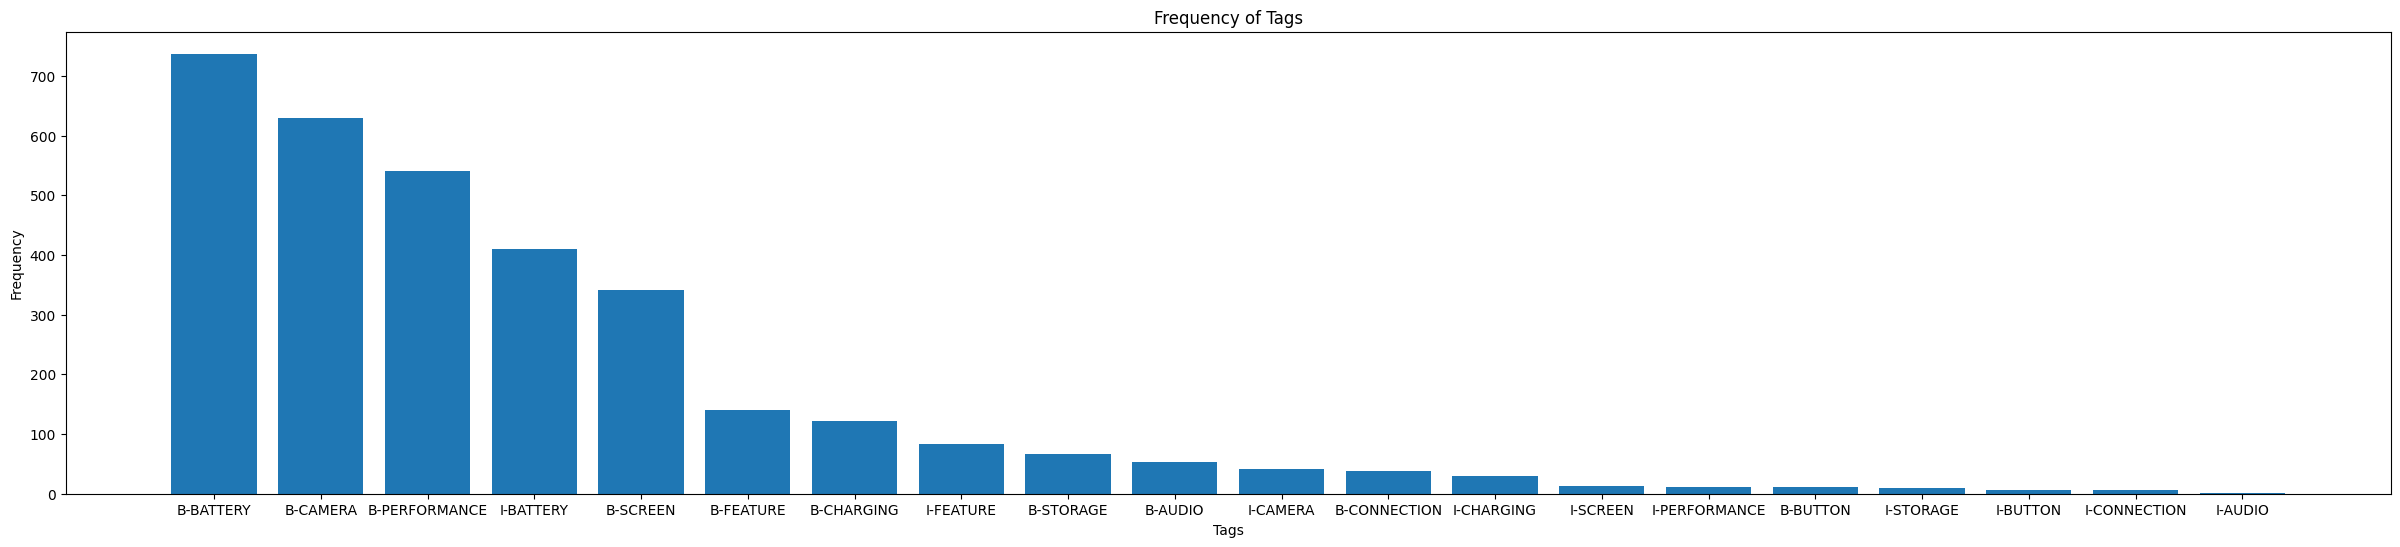

In [19]:
temp_df = NER_df.drop(NER_df[NER_df['labels'] == 'O'].index)
label_counts = temp_df['labels'].value_counts()
plt.figure(figsize=(30, 6))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.title('Frequency of Tags')
plt.show()

### **Save IOB format tag**

In [20]:
NER_df.to_csv('../datasets/dataset-iob-tag.csv', index=False)

## **Train**

In [21]:
TRAIN_ARGS = TrainingArguments('../model/review_NER',
	num_train_epochs=9,
	evaluation_strategy='epoch',
	save_strategy='epoch',
	load_best_model_at_end=True,
	push_to_hub=False
)

MODEL_NAME = 'dslim/distilbert-NER'
X = NER_df[["sentence_id","words"]]
Y = NER_df["labels"]
LABEL = ['O',
 'B-STORAGE',
 'B-PERFORMANCE',
 'B-BATTERY',
 'I-BATTERY',
 'B-CAMERA',
 'I-CAMERA',
 'B-CHARGING',
 'I-CHARGING',
 'I-STORAGE',
 'I-PERFORMANCE',
 'B-SCREEN',
 'I-SCREEN',
 'B-AUDIO',
 'B-FEATURE',
 'I-FEATURE',
 'B-CONNECTION',
 'I-CONNECTION',
 'B-BUTTON',
 'I-BUTTON',
 'I-AUDIO']
NUM_LABELS = len(LABEL)
TOKENIZER = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

c:\USERS\VINAR\ONEDRIVE - BINA NUSANTARA\MY PROJECT\TEST-JUPYTER\MY_ENV\Lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\vinar\.cache\huggingface\hub\models--dslim--distilbert-NER. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    f1 = f1_score(labels, predictions, average='weighted')
    return {"f1-score": f1}

In [ ]:
train, test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)

trainer = Trainer(
	model=model,
	args=TRAIN_ARGS,
	train_dataset=train,
	eval_dataset=test,
	tokenizer=TOKENIZER,
	compute_metrics=compute_metrics
)

trainer.train()

In [ ]:
results = trainer.evaluate()
print(f'Evaluation results: {results}')